Caroline Richards

In [175]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# I. Data Wrangling

In [176]:
# load the data
file_path = '/Users/richa/OneDrive/Documents/MATH 446/Datasets/new_scores.csv'
grading_df = pd.read_csv(file_path, index_col='student_id')

In the initial loading of the new score dataset, I read in the file by indexing the data frame according to student identification, a numerical value. Before performing any processing on the grades, any students that did not take the final exam must be removed from the data frame. To identify those students, the isna() and sum() functions are utilized to determine the number of students who are missing the final exam. In order to remove these students from the dataframe, I utilized the pandas loc() function in combination with the isna() function and the ‘~’ identifier to exclude any rows where the final exam was a null value. Once those students were removed, data aggregation and processing could be performed.


## a. Clean up the data

The function isna() is from the Pandas library and identifies null values in a Pandas Data Frame by mapping those values to booleans in a same-sized object. When isna() is used in combination with sum(), a table of summations of the 'true' booleans indicating the presence of a null value are returned.

In [177]:
# finding the missing midterms, quizes, exams, etc.
grading_df.isna().sum()

final        2
midterm_1    1
midterm_2    0
midterm_3    1
quiz_1       1
quiz_2       0
quiz_3       0
quiz_4       0
quiz_5       0
quiz_6       1
quiz_7       1
quiz_8       1
quiz_9       2
quiz_10      2
quiz_11      2
dtype: int64

### 1. Remove students who did not take the final

The loc() method from Pandas allows for access of specific Data Frame contents by index or column.The loc() attribute is used in this example to select the final column and specifically those values which are null values and display those rows. 

In [178]:
# there are two missing final exams, so these students cannot receive a course letter grade
grading_df.loc[grading_df.final.isna(), :]

,final,midterm_1,midterm_2,midterm_3,quiz_1,quiz_2,quiz_3,quiz_4,quiz_5,quiz_6,quiz_7,quiz_8,quiz_9,quiz_10,quiz_11
student_id,,,,,,,,,,,,,,,
3063221178,NaN,77.0,60.0,40.0,NaN,4.0,8.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5369149961,NaN,63.0,52.0,NaN,7.0,5.0,7.0,4.0,0.0,9.0,4.0,0.0,NaN,NaN,NaN


In [179]:
# remove the ones with missing finals
grading_df = grading_df.loc[~grading_df.final.isna(), :]

### 2. Determine students with other missing exams

In [180]:
# determine if there are other missing exams
grading_df.isna().sum()

final        0
midterm_1    1
midterm_2    0
midterm_3    0
quiz_1       0
quiz_2       0
quiz_3       0
quiz_4       0
quiz_5       0
quiz_6       0
quiz_7       0
quiz_8       0
quiz_9       0
quiz_10      0
quiz_11      0
dtype: int64

# II. Averaging

## a. Quiz Averages

The first step in processing the student performance data for grade and GPA determination is to aggregate the students' quizzes and determine the average quiz grade for each individual student. I used the dictionary mapping process and created a data frame of quizzes to aggregate into the quiz average. 

The grading criteria stipulates that the lowest two quiz scores must be dropped before taking the quiz average from the aggregated data. To achieve this, I utilized the .iloc() applied to the quiz data frame to access every row. I then utilized the apply() function  in combination with lambda and NumPy arrays to calculate the average of each student's quiz. Inside the apply function, a lambda formula is defined to iterate by row where each row in the quiz data frame represents a single student’s performance. Each row is then treated as a NumPy array that is sorted in ascending order. The average of the quiz scores in the array is then taken starting from the index of 2 which would be the third lowest score as stipulated in the grading requirements.


In [181]:
quiz_df = pd.DataFrame({"quiz_" + str(k): grading_df['quiz_' + str(k)] for k in range(1, 12)})
agg_df = pd.DataFrame({'Final':grading_df['final']})
agg_df['Quiz_Avg'] = quiz_df.iloc[:, 1:].apply(lambda row: np.mean(np.sort(row)[2:]), axis=1)
agg_df.head()

,Final,Quiz_Avg
student_id,,
1367593690,96.0,6.875
1567876630,69.0,7.375
1617655608,94.0,7.875
1830694822,52.0,6.500
2267294565,79.0,8.375


## b. Midterm Averaging

As previously conducted, the only other null value in the data frame is in the ‘midterm_1’ column. To determine the index position of this null value, I utilized the loc() method and the isna() function.

In [182]:
# a midterm was missed but the final exam was taken
# infer from a linear regression of the midterm 1 aginast the quiz avg
grading_df.loc[grading_df.midterm_1.isna(), :]

,final,midterm_1,midterm_2,midterm_3,quiz_1,quiz_2,quiz_3,quiz_4,quiz_5,quiz_6,quiz_7,quiz_8,quiz_9,quiz_10,quiz_11
student_id,,,,,,,,,,,,,,,
8996487694,19.0,NaN,16.0,26.0,4.0,0.0,0.0,3.0,2.5,0.0,4.5,3.5,3.0,5.5,8.0


### 1. Regression of Midterm Avg and Quiz

Grading criteria requires that the predicted value from the regression of the quiz average against the specific midterm can replace a missing midterm score for those students who have taken the final exam. In order to replace the null value of “midterm_1” for students [8996487694], I first ran regression analysis on the specified attributes of the data frame. I created two separate data frames of the quiz averages and the midterm 1 grades identified by student ID values to be used in merging the data frames. Upon reflection, this merger was wholly unnecessary as a single data frame could have been created and used instead of creating and merging two data frames. .


I then separated the data frame into two datasets, a training dataset and a test dataset. The training dataset consisted of every instance/student that did not have a null-value for midterm 1 while the test dataset consisted of the student who missed midterm 1.

In [183]:
# the missing midterm is in midterm 1
mid1_df = pd.DataFrame({'mid1':grading_df['midterm_1'], 'stu_id':grading_df.index.values})
quiz_avg_df = pd.DataFrame({'qavg':agg_df['Quiz_Avg'], 'stu_id':grading_df.index.values})

reg_df = pd.merge(mid1_df, quiz_avg_df, on = 'stu_id')

# rows with non-null values
training_data = reg_df.dropna()
# rows with null values
testing_data = reg_df[reg_df['mid1'].isna()]

Once the datasets were separated, I utilized the scikit-learn Linear Regression function to create a regression model instance. I identified the quiz averages as the x-values  and the midterm 1 grades as the y-values in the training dataset. With the x- and y- values identified, I fit the training dataset to the regression model instance. Using the coef_ and intercept_ methods the model produced was the following:

$y = 5.73455459(qavg) + 30.53118193033194$

In [184]:
#create regression model
reg_model = LinearRegression()
x_train = training_data[['qavg']]
y_train = training_data['mid1']
reg_model.fit(x_train, y_train)

LinearRegression()

In [200]:
reg_model.coef_

array([5.73455459])

In [201]:
reg_model.intercept_

30.53118193033194

### 2. Predicting the Midterm Value

Once the regression model was run on the training data and a model was produced, I could then utilize the test data’s quiz average value to predict a midterm 1 value. The scikit-learn Linear Regression includes the predict() function that takes the defined x-value as an argument and applies it to the model. Once the value for the missing midterm one was predicted, I retrieved the student ID index previously identified and replaced the null value with the predicted value.

In [185]:
# predict the missing values
x_test = testing_data[['qavg']]
miss_mid_predict = reg_model.predict(x_test)

# update data with predicted
grading_df.midterm_1[8996487694] = miss_mid_predict

### 3. Calculating Midterm Averages

With no null midterm scores, I utilized the dictionary mapping process once more to create a midterm data frame indexed by student. I defined a midterm averaging function to calculate the weight of each midterm by score. In my function, I made each row of the midterm data frame into a NumPy array which held each of the three midterm scores for a single student. I then sorted the midterms and applied a 20% weight to the zero-index or lowest midterm score, 35% weight to the one-index, and 45% weight to the two-index or highest score and returned their sum as the midterm average.

In [186]:
midterm_df = pd.DataFrame({"midterm_" + str(k): grading_df['midterm_' + str(k)] for k in range(1, 4)})

def mid_avg(x):
    m = np.array(x)
    m.sort()
    avg = m[0]*0.2 + m[1]*0.35 + m[2]*0.45
    return avg

agg_df['Midterm_Avg'] = midterm_df.apply(mid_avg, axis=1)

## c. Course Grade

To determine the course grade as indicated by the grading criteria, I defined a function which took the aggregate data frame rows and set their attribute values in a corresponding NumPy array. I initially added Final exam scores to the aggregate data frame first, then quiz average, then midterm average, as such my indexes were as follows: final exam at index zero, quiz average at index 1, and midterm average at index 2. I calculated students’ weighted course grades in correspondence with these indexes with quiz average at 15%, midterm average at 45%, and final exam at 40%.

In [190]:
def weighted_grade(x):
    w = np.array(x)
    wgrade = w[0]*0.40 + w[1]*0.15 + w[2]*0.45
    return wgrade

agg_df['Weighted_Course_Grade'] = agg_df.apply(weighted_grade, axis=1)

## d. Aggregated/Avg Dataframe

In [191]:
agg_df

,Final,Quiz_Avg,Midterm_Avg,Weighted_Course_Grade
student_id,,,,
1367593690,96.0,6.8750,64.750000,68.568750
1567876630,69.0,7.3750,75.700000,62.771250
1617655608,94.0,7.8750,75.350000,72.688750
1830694822,52.0,6.5000,56.950000,47.402500
2267294565,79.0,8.3750,69.600000,64.176250
2328480380,118.0,8.5000,90.600000,89.245000
2503055012,75.0,7.5000,80.250000,67.237500
2933314271,113.0,9.6875,95.800000,89.763125
3013545559,60.0,7.8750,80.350000,61.338750


# III. Letter Grade Determination

## a. EDA

I utilized the MatPlot Library to create a two-by-two display of four subplots. In each plot I then utilized the seaborn library to generate density histograms of each exam grade or average and course grade with 12 bins to represent the 12 letter grades.

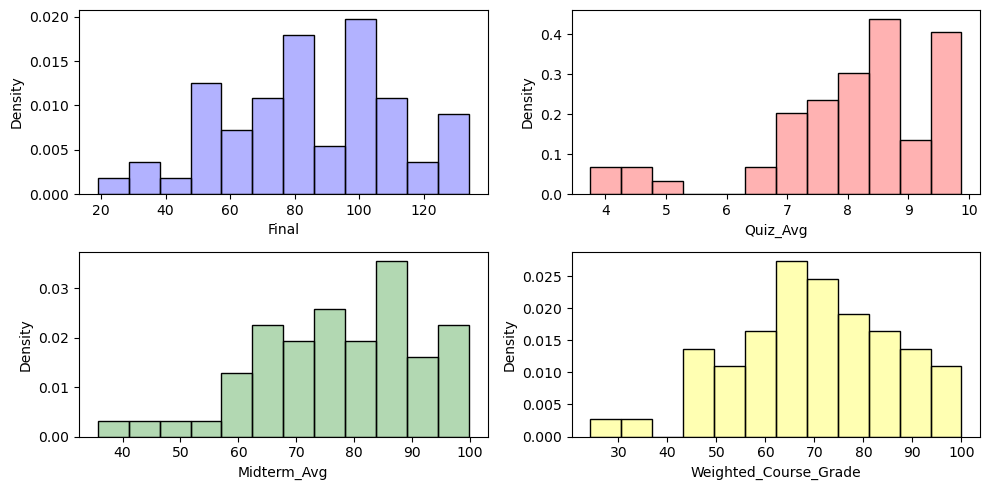

In [192]:
# Exploratory Data Analysis
fig, ax = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

sns.histplot(agg_df, x="Final", stat='density', fill=True, alpha=0.3, legend=True, bins = 12, color='blue', ax=ax[0, 0]);
sns.histplot(agg_df, x="Quiz_Avg", stat='density', fill=True, alpha=0.3, legend=True, bins = 12, color='red', ax=ax[0, 1]);
sns.histplot(agg_df, x="Midterm_Avg", stat='density', fill=True, alpha=0.3, legend=True, bins = 12, color='green', ax=ax[1, 0]);
sns.histplot(agg_df, x="Weighted_Course_Grade", stat='density', fill=True, alpha=0.3, legend=True, bins = 12, color='yellow', ax=ax[1, 1]);

## b. Cut-offs and Bin-Sizing using pd.cut()

Upon observing the structure of the score data in histogram plots, I decided to use the NumPy arange() function to create same-sized arrays that would function as bins to separate the score data for each attribute. Since there are 12 available letter grades, I identified the starting value of the array to be zero and the step value to be 1 + 1/12  1/12. This generated 12 bins that could be assigned to each of the 12 letter grades or regular GPAvalues. Since there are 13 rather than 12 weighted GPA values, the step was changed 1/13ths instead of 1/12ths to account for each value. I then Identified the lists of GPA, weighted GPA, and letter grade values.

In [213]:
final_bins = agg_df.Final.quantile(np.arange(0, 1 + 1/12, 1/12))
final_bins [0] = 0
mid_bins = agg_df.Midterm_Avg.quantile(np.arange(0, 1 + 1/12, 1/12))
mid_bins [0] = 0
quiz_bins = agg_df.Quiz_Avg.quantile(np.arange(0, 1 + 1/12, 1/12))
quiz_bins [0] = 0
course_bins = agg_df.Weighted_Course_Grade.quantile(np.arange(0, 1 + 1/12, 1/12))
course_bins [0] = 0
course_gpa_bins = agg_df.Weighted_Course_Grade.quantile(np.arange(0, 1 + 1/13, 1/13))
course_gpa_bins [0] = 0

gpa = [0, 0.7, 1.0, 1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 4.0]
weight_gpa = [0, 0.55, 0.85, 1.15, 1.55, 1.85, 2.15, 2.55, 2.85, 3.15, 3.55, 3.85, 4.0]
letter = ["F", "D-", "D", "D+", "C-", "C", "C+", "B-", "B", "B+", "A-", "A"]

With bin sizes determined, I could apply the Pandas cut() function to the aggregate data frame to assign GPA and letter grade values to appropriate exam and course grades. The "bins" arguments correspond to the respective quantile arrays calculated with the aforementioned NumPy arange() function. The list of letters and GPA values are indicated as "labels" for corresponding bins in the data frame according to grading criteria.

In [214]:
Final_GPA = pd.cut(agg_df.Final, bins=final_bins, labels = gpa, include_lowest=True, ordered=True, precision=2)
Quiz_GPA = pd.cut(agg_df.Quiz_Avg, bins=quiz_bins, labels = gpa, include_lowest=True, ordered=True, precision=2)
Midterm_GPA = pd.cut(agg_df.Midterm_Avg, bins=mid_bins, labels = gpa, include_lowest=True, ordered=True, precision=2)
Course_Weighted_GPA = pd.cut(agg_df.Weighted_Course_Grade, bins=course_gpa_bins, labels = weight_gpa, include_lowest=True, ordered=True, precision=2)
Course_Letter_Grade = pd.cut(agg_df.Weighted_Course_Grade, bins=course_bins, labels = letters, include_lowest=True, ordered=True, precision=2)

# IV. Final Score Data

Once every score for each student was assigned a GPA or letter grade, I used the Pandas DataFrame() function to create a final data frame with the assigned grade values and letters corresponding to each individual student determined by the cut() function. 

In [225]:
score_df = pd.DataFrame(data = {'Quiz_GPA': Quiz_GPA, 'Midterm_GPA': Midterm_GPA, 'Final_GPA': Final_GPA, 
                                'Course_Weighted_GPA' : Course_Weighted_GPA, 'Course_Letter_Grade' : Course_Letter_Grade })

The grading criteria requires student scores to be sorted by Course Weighted GPA in descending order beginning with 4.00. To achieve this, I utilized the loc method to ensure an entire row was being sorted with its corresponding attributes rather than sorting a single attribute column. I then applied the sort_values() function to sort rows by the ‘Course_Weighted_GPA’ attribute and indicated descending order by setting ascending equal to False. To visualize the results of this sorting, I applied the head method with an argument of 10 to display the first ten rows.


In [229]:
score_df.loc[:, [ 'Quiz_GPA', 'Midterm_GPA','Final_GPA',
                 'Course_Weighted_GPA','Course_Letter_Grade' ]].sort_values('Course_Weighted_GPA', ascending=False).head(10)

,Quiz_GPA,Midterm_GPA,Final_GPA,Course_Weighted_GPA,Course_Letter_Grade
student_id,,,,,
5856390535,4.0,3.7,4.0,4.00,A
2933314271,3.7,3.7,3.7,4.00,A
8223787343,4.0,4.0,4.0,4.00,A
6011937372,4.0,4.0,4.0,4.00,A
4916395511,3.3,4.0,4.0,4.00,A
3753516619,3.7,2.7,4.0,3.85,A-
3687160969,3.3,3.7,3.7,3.85,A-
9882408935,3.7,3.7,3.3,3.85,A-
2328480380,2.7,3.3,3.7,3.85,A-


# V. Review

In review, there are ways in which I could have consolidated this process. I could have minimized my use of data frame creation and expanded on my implementation of function definition and use of NumPy arrays. However, the speed at which the code operates is notable. It is particularly notable that the use of loops was unnecessary, allowing for increased efficiency.  